<a href="https://colab.research.google.com/github/PraphulSamavedam/nn-bio-tech/blob/main/medical_mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from torch import nn
from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Work/medicalMNIST/')

data_dir = "data/"
annotations_dir = "annotations/"
output_dir = "output/"

Mounted at /content/drive


In [ ]:
# data_dir = "/kaggle/input/medical-mnist/"
# annotations_dir = "/kaggle/working/annotations/"
# output_dir = "/kaggle/working/output/"



if not os.path.exists(annotations_dir):
    os.makedirs(annotations_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# EDA
- Number of classes
    - Multi-class classification
- Number of samples per class

In [3]:
classes = os.listdir(data_dir)
number_classes = len(classes)


In [ ]:
classes_info_dict = {}
for _class in classes:
    class_path = os.path.join(data_dir,_class)
    samples = os.listdir(class_path)
    samples = samples[:100]
    temp_dict = dict()
    temp_dict['samples_list'] = samples
    temp_dict['number_of_samples'] = len(samples)
    temp_dict['folder_path'] = class_path
    classes_info_dict[_class] = temp_dict
    print(f"Number of samples of class '{_class}' are {temp_dict['number_of_samples']}.")
    del temp_dict

Number of samples of class 'AbdomenCT' are 100.
Number of samples of class 'BreastMRI' are 100.
Number of samples of class 'ChestCT' are 100.
Number of samples of class 'HeadCT' are 100.
Number of samples of class 'CXR' are 100.
Number of samples of class 'Hand' are 100.


In [ ]:
import seaborn as sns

classes = [key for key in classes_info_dict.keys()]
sample_counts = [classes_info_dict[_class]['number_of_samples'] for _class in classes]

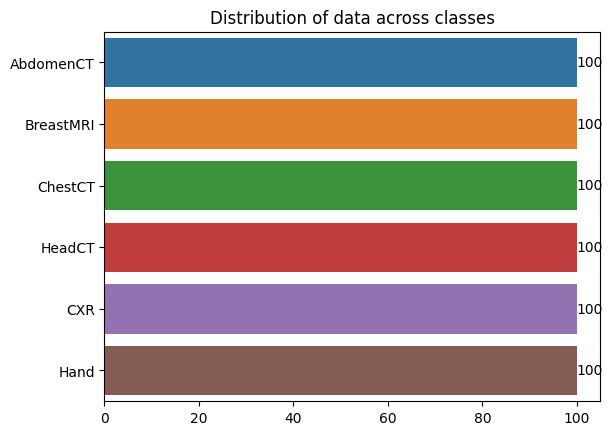

In [ ]:
sample_counts, classes
ax = sns.barplot(y=classes, x= sample_counts, orient='h')
plt.title("Distribution of data across classes")
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
from random import shuffle
train_ratio = 0.70
valid_ratio = 0.0
test_ratio = 0.30
batch_size = 1024
shufle = True
train_file = f"{annotations_dir}train_annotations.csv"
test_file = f"{annotations_dir}test_annotations.csv"
valid_file = f"{annotations_dir}valid_annotations.csv"

for file in [train_file, test_file, valid_file]:
    with open(file=file, mode='w') as filehandle:
        filehandle.write("")
indx = 0
label_mapping = dict()
for _class in classes_info_dict:
    samples = classes_info_dict[_class]['samples_list']
    number_of_samples = classes_info_dict[_class]['number_of_samples']
    training_sample_count =  int(train_ratio*number_of_samples)
    validation_sample_count = int(valid_ratio*number_of_samples)
    testing_sample_count = number_of_samples - training_sample_count - validation_sample_count
    shuffle(samples)
    training_data = samples[:training_sample_count]
    validation_data = samples[training_sample_count:training_sample_count+validation_sample_count]
    testing_data = samples[training_sample_count+validation_sample_count:]
    folder_path = classes_info_dict[_class]['folder_path']
    label_mapping[indx] = _class
    with open(train_file,'a') as file:
        for data_point in training_data:
            file_path = os.path.join(folder_path, data_point)
            file.write(f"{file_path},{indx}\n")
            
    with open(test_file, 'a') as file:
        for data_point in testing_data:
            file_path = os.path.join(folder_path, data_point)
            file.write(f"{file_path},{indx}\n")
    
    with open(valid_file, 'a') as file:
        for data_point in validation_data:
            file_path = os.path.join(folder_path, data_point)
            file.write(f"{file_path},{indx}\n")

    print(f"Train:{len(training_data)}, Valid:{len(validation_data)}, Test:{len(testing_data)}")
    indx += 1

print("Successfully created training, validation and test datasets")

Train:70, Valid:0, Test:30
Train:70, Valid:0, Test:30
Train:70, Valid:0, Test:30
Train:70, Valid:0, Test:30
Train:70, Valid:0, Test:30
Train:70, Valid:0, Test:30
Successfully created training, validation and test datasets


In [ ]:
label_mapping

{0: 'AbdomenCT',
 1: 'BreastMRI',
 2: 'ChestCT',
 3: 'HeadCT',
 4: 'CXR',
 5: 'Hand'}

## Arranging data in datasets

### Creating dataset

In [15]:
class CustomDataset(Dataset):
    """
    This class provides requierd functions to properly extend Dataset class
    """
    
    def __init__(self, csv_file_path:str, transform=None, target_transform=None):
        """Initialization with annotations file, optional transformations"""
        self.csv_file_path = csv_file_path
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        """This function returns the total number of samples in the dataset."""
        csv_data = pd.read_csv(self.csv_file_path)
        return csv_data.shape[0]
    
    def __getitem__(self, indx):
        """This function provides the image data and label of the next item."""
        csv_data = pd.read_csv(self.csv_file_path)
        image_file_path, label = csv_data.iloc[indx,:]
        image = Image.open(image_file_path)
        width, height = 28, 28
        pre_process_image = torchvision.transforms.Compose([transforms.Resize((height, width)),
                                                            transforms.ToTensor()])
        image_data = pre_process_image(image)
        if self.transform:
            image_data= self.transform(image_data)
        if self.target_transform:
            label = self.target_transform(label)
        return image_data, label

In [16]:
transform_image = torchvision.transforms.Compose([transforms])

In [ ]:
training_data = CustomDataset(train_file, None, None)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shufle)

testing_data = CustomDataset(test_file, None, None)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=shufle)

# validation_data = CustomDataset(valid_file, None, None)
# valid_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=shufle)

### Display image and label.

In [ ]:
# train_features, train_labels = next(iter(train_dataloader))
# img = train_features[0].squeeze()
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.title(f"Label: {label_mapping[label.detach().item()]}")
# plt.show()

In [ ]:
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


In [5]:
import torch
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

1


In [6]:
class CustomNeuralNetwork(nn.Module):
    """This class describes the custom neural network module"""
    def __init__(self, number_of_channels:int, number_of_classes:int):
        super().__init__()
        # Pad to have same dimensions -> Get different perspectives of the image
        self.conv1 = nn.Conv2d(in_channels= number_of_channels, out_channels= 64, kernel_size=3, padding= 1)
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(num_features=64)
        # Output size: 1 x 28 x 28 -> 64 x 28 x 28

        self.conv2 = nn.Conv2d(in_channels= 64, out_channels= 32, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        # Output size = 64 x 28 x 28 -> 32 x 26 x 26
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        # Output size = 32 x 13 x 13
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        # Output size = 64 x 6 x 6
        self.relu3 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=3)
        # Output size = 64 x 3 x 3
        
        self.flat = nn.Flatten()
        # Output size = 9 x 64 = 576
        self.lin1 = nn.Linear(in_features = 576, out_features= 64, bias=True)
        self.lin2 = nn.Linear(in_features= 64, out_features=number_classes, bias=True)
        
    def forward(self, data):
        # Pass through first convolution block
        data = self.conv1(data)
        data = self.relu1(data)
        data = self.norm1(data)
        
        # Pass through second convolution block.
        data = self.conv2(data)
        data = self.relu2(data)
        data = self.maxpool1(data)

        # Pass through convoloution block-3
        data = self.conv3(data)
        data = self.relu3(data)
        data = self.maxpool2(data)

        # Linearize the data
        data = self.flat(data)

        # Full connect layers
        data = self.lin1(data)
        data = self.lin2(data)
        return data

In [ ]:
model = CustomNeuralNetwork(1, len(classes))

In [ ]:
print(f"Model structure: {model}\n\n")

Model structure: CustomNeuralNetwork(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=3, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=576, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=6, bias=True)
)




In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

Layer: conv1.weight | Size: torch.Size([64, 1, 3, 3])
Layer: conv1.bias | Size: torch.Size([64])
Layer: norm1.weight | Size: torch.Size([64])
Layer: norm1.bias | Size: torch.Size([64])
Layer: conv2.weight | Size: torch.Size([32, 64, 3, 3])
Layer: conv2.bias | Size: torch.Size([32])
Layer: conv3.weight | Size: torch.Size([64, 32, 3, 3])
Layer: conv3.bias | Size: torch.Size([64])
Layer: lin1.weight | Size: torch.Size([64, 576])
Layer: lin1.bias | Size: torch.Size([64])
Layer: lin2.weight | Size: torch.Size([6, 64])
Layer: lin2.bias | Size: torch.Size([6])


In [ ]:
# loss_funcn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, dvice):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(dvice)
        y = y.to(dvice)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return loss

def test_loop(dataloader, model, loss_fn, dvice):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(dvice)
            y = y.to(dvice)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.4f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [ ]:
def save_best_model(model, train_losses:list, test_losses:list, test_accuracy:float, epoch:int):
  torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'test_accuracy': test_accuracy,
    'epoch':epoch,
    }, f'{output_dir}best_model.pth')
  print("Saved best model till now ")

def save_model(model, train_losses:list, test_losses:list, test_accuracy:float, epoch:int ):
  torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'test_accuracy': test_accuracy,
    'epoch':epoch,
    }, f'{output_dir}model.pth')

In [ ]:
from math import inf
epochs = 350 # 300 -> 350 

test_losses = []
train_losses = []

model = CustomNeuralNetwork(1, len(classes))
model = torch.nn.DataParallel(model).to(device)
# model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
# learning_rate = 1e-3 # 1e-3 = 0.001
learning_rate = 0.03
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
min_train_loss, min_test_loss, max_accuracy = +inf, inf, -inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f"Epoch = {epoch + 1}, \nTest ", end="")
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    save_model(model, train_losses, test_losses, test_accuracy, epoch)

    if (train_loss <= min_train_loss) & ( test_loss <= min_test_loss):
      save_best_model(model, train_losses, test_losses, test_accuracy, epoch)
    print("Done!")

Epoch 1
-------------------------------
loss: 1.795034  [  419/  419]
Epoch = 1, 
Test Accuracy: 16.7598%, Avg loss: 1.792527 

Saved best model till now 
Done!
Epoch 2
-------------------------------
loss: 1.792344  [  419/  419]
Epoch = 2, 
Test Accuracy: 16.7598%, Avg loss: 1.792033 

Saved best model till now 
Done!
Epoch 3
-------------------------------
loss: 1.791816  [  419/  419]
Epoch = 3, 
Test Accuracy: 18.9944%, Avg loss: 1.791545 

Saved best model till now 
Done!
Epoch 4
-------------------------------
loss: 1.791298  [  419/  419]
Epoch = 4, 
Test Accuracy: 18.9944%, Avg loss: 1.791062 

Saved best model till now 
Done!
Epoch 5
-------------------------------
loss: 1.790790  [  419/  419]
Epoch = 5, 
Test Accuracy: 21.2291%, Avg loss: 1.790574 

Saved best model till now 
Done!
Epoch 6
-------------------------------
loss: 1.790281  [  419/  419]
Epoch = 6, 
Test Accuracy: 22.9050%, Avg loss: 1.790063 

Saved best model till now 
Done!
Epoch 7
--------------------------

In [ ]:
model_path = f"{output_dir}best_model.pth"

In [7]:
def load_model(device:str, model_path:str=None):
  mod = CustomNeuralNetwork(1, len(classes)).to(device)
  checkpoint = torch.load(model_path)
  state_dict = {k.replace('module.', ''): v for k, v in checkpoint['model_state_dict'].items()}
  mod.load_state_dict(state_dict)
  mod.eval()
  return mod

In [8]:
mod = load_model(device, f'{output_dir}best_model.pth')

# Evaluating the best model performance

In [9]:
print(f"Train ", end="")
_, _ = test_loop(train_dataloader,mod,loss_fn,device)
print(f"Test ", end="")
_, _ = test_loop(test_dataloader,mod,loss_fn,device)

Train 

NameError: ignored

# Evaluation on complete set

In [12]:
classes_info_dict = dict()
for _class in classes:
    class_path = os.path.join(data_dir,_class)
    samples = os.listdir(class_path)
    temp_dict = dict()
    temp_dict['samples_list'] = samples
    temp_dict['number_of_samples'] = len(samples)
    temp_dict['folder_path'] = class_path
    classes_info_dict[_class] = temp_dict
    print(f"Number of samples of class '{_class}' are {temp_dict['number_of_samples']}.")
    del temp_dict

Number of samples of class 'AbdomenCT' are 10010.
Number of samples of class 'BreastMRI' are 8964.
Number of samples of class 'ChestCT' are 10000.
Number of samples of class 'HeadCT' are 10000.
Number of samples of class 'CXR' are 10000.
Number of samples of class 'Hand' are 10020.


In [13]:
from random import shuffle
train_ratio = 0.70
valid_ratio = 0.10
test_ratio = 0.20
shufle = True
train_file = f"{annotations_dir}train_annotations.csv"
test_file = f"{annotations_dir}test_annotations.csv"
valid_file = f"{annotations_dir}valid_annotations.csv"

for file in [train_file, test_file, valid_file]:
    with open(file=file, mode='w') as filehandle:
        filehandle.write("")
indx = 0
label_mapping = dict()
for _class in classes_info_dict:
    samples = classes_info_dict[_class]['samples_list']
    number_of_samples = classes_info_dict[_class]['number_of_samples']
    training_sample_count =  int(train_ratio*number_of_samples)
    validation_sample_count = int(valid_ratio*number_of_samples)
    testing_sample_count = number_of_samples - training_sample_count - validation_sample_count
    shuffle(samples)
    training_data = samples[:training_sample_count]
    validation_data = samples[training_sample_count:training_sample_count+validation_sample_count]
    testing_data = samples[training_sample_count+validation_sample_count:]
    folder_path = classes_info_dict[_class]['folder_path']
    label_mapping[indx] = _class
    with open(train_file,'a') as file:
        for data_point in training_data:
            file_path = os.path.join(folder_path, data_point)
            file.write(f"{file_path},{indx}\n")
            
    with open(test_file, 'a') as file:
        for data_point in testing_data:
            file_path = os.path.join(folder_path, data_point)
            file.write(f"{file_path},{indx}\n")
    
    with open(valid_file, 'a') as file:
        for data_point in validation_data:
            file_path = os.path.join(folder_path, data_point)
            file.write(f"{file_path},{indx}\n")

    print(f"Class: {_class} has Train:{len(training_data)}, Valid:{len(validation_data)}, Test:{len(testing_data)}")
    indx += 1

print("Successfully created training, validation and test datasets")

Class: AbdomenCT has Train:7007, Valid:1001, Test:2002
Class: BreastMRI has Train:6274, Valid:896, Test:1794
Class: ChestCT has Train:7000, Valid:1000, Test:2000
Class: HeadCT has Train:7000, Valid:1000, Test:2000
Class: CXR has Train:7000, Valid:1000, Test:2000
Class: Hand has Train:7014, Valid:1002, Test:2004
Successfully created training, validation and test datasets


In [17]:
batch_size = 4096
training_data = CustomDataset(train_file, None, None)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shufle)

testing_data = CustomDataset(test_file, None, None)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=shufle)

validation_data = CustomDataset(valid_file, None, None)
valid_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=shufle)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# learning_rate = 1e-3 # 1e-3 = 0.001
# learning_rate = 0.03
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Train ", end="")
_, _ = test_loop(train_dataloader,mod,loss_fn,device)

print(f"Validation ", end="")
_, _ = test_loop(valid_dataloader,mod,loss_fn,device)

print(f"Test ", end="")
_, _ = test_loop(test_dataloader,mod,loss_fn,device)


Train 